# Post-process and split data 

In [1]:
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ms2deepscore import SpectrumBinner
from ms2deepscore.models import SiameseModel

path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(os.path.dirname(path_root), "Data")  # add your local data folder here

In [2]:
def count_annotations(spectrums):
    inchi_lst = []
    smiles_lst = []
    inchikey_lst = []
    for i, spec in enumerate(spectrums):
        inchi_lst.append(spec.get("inchi"))
        smiles_lst.append(spec.get("smiles"))
        inchikey = spec.get("inchikey")
        if inchikey is None:
            inchikey = spec.get("inchikey_inchi")
        inchikey_lst.append(inchikey)

    inchi_count = sum([1 for x in inchi_lst if x])
    smiles_count = sum([1 for x in smiles_lst if x])
    inchikey_count = sum([1 for x in inchikey_lst if x])
    print("Inchis:", inchi_count, "--", len(set(inchi_lst)), "unique")
    print("Smiles:", smiles_count, "--", len(set(smiles_lst)), "unique")
    print("Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), "unique (first 14 characters)")

## Load positive ionmode spectrums

In [3]:
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_positive_cleaned.pickle')
with open(filename, 'rb') as file:
    spectrums = pickle.load(file)

print(f"{len(spectrums)} spectra imported.")

373405 spectra imported.


## Creating a subselection with only fully annotated spectra
- all annotated with InChIKey + SMILES and/or InChI
- all positive ionization mode

In [4]:
spectrums_pos_annotated = []
for spec in spectrums:
    inchikey = spec.get("inchikey")
    if inchikey is not None and len(inchikey) > 13:
        if spec.get("smiles") or spec.get("inchi"):
            spectrums_pos_annotated.append(spec)

len(spectrums_pos_annotated)

359574

In [5]:
count_annotations(spectrums_pos_annotated)

Inchis: 359574 -- 21209 unique
Smiles: 359574 -- 27823 unique
Inchikeys: 359574 -- 17579 unique (first 14 characters)


In [6]:
number_of_peaks = np.array([len(s.peaks) for s in spectrums])

print(f"{np.sum(number_of_peaks < 10)} spectra have < 10 peaks")
print(f"{np.sum(number_of_peaks < 5)} spectra have < 5 peaks")
print(f"{np.sum(number_of_peaks < 2)} spectra have < 2 peaks")
print(f"{np.sum(number_of_peaks < 1)} spectra have < 1 peaks")

173051 spectra have < 10 peaks
109355 spectra have < 5 peaks
43937 spectra have < 2 peaks
0 spectra have < 1 peaks


In [7]:
pickle.dump(spectrums_pos_annotated, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_positive_annotated.pickle'), "wb"))

# First data exploration

## Many spectra contain very few peaks!
- We here remove spectra with less than 5 peaks with m/z values in the range between 10.0 and 1000.0 Da
- We then make another subselection of only spectra which are fully annotated (InChIKey + SMILES/InChI)

In [6]:
number_of_peaks = np.array([len(s.peaks) for s in spectrums])

print(f"{np.sum(number_of_peaks < 10)} spectra have < 10 peaks")
print(f"{np.sum(number_of_peaks < 5)} spectra have < 5 peaks")
print(f"{np.sum(number_of_peaks < 2)} spectra have < 2 peaks")
print(f"{np.sum(number_of_peaks < 1)} spectra have < 1 peaks")

173051 spectra have < 10 peaks
109355 spectra have < 5 peaks
43937 spectra have < 2 peaks
0 spectra have < 1 peaks


## Creating a processed subselection with only fully annotated spectra
- all positive ionization mode spectra which are annotated with InChIKey + SMILES and/or InChI
- normalize peaks
- remove peaks with intensities < 0.001
- remove spectra with < 5 peaks with m/z between 10.0 and 1000.0 Da

In [11]:
from matchms.filtering import select_by_intensity, select_by_mz
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks

def minimal_processing(spectrum, max_mz=1000.0, intensity_from=0.001, n_required=5):
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=np.inf)
    spectrum = select_by_intensity(spectrum,
                                   intensity_from=intensity_from)
    if spectrum.peaks.mz[spectrum.peaks.mz < max_mz].size < n_required:
        return None
    return spectrum

In [12]:
from tqdm.notebook import tqdm

spectrums_pos_processed = [minimal_processing(s) for s in tqdm(spectrums_pos_annotated)]
spectrums_pos_processed = [s for s in spectrums_pos_processed if s is not None]
count_annotations(spectrums_pos_processed)

  0%|          | 0/359574 [00:00<?, ?it/s]

Inchis: 250129 -- 20393 unique
Smiles: 250129 -- 26755 unique
Inchikeys: 250129 -- 17105 unique (first 14 characters)


In [16]:
pickle.dump(spectrums_pos_processed, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_positive_processed_annotated.pickle'), "wb"))
len(spectrums_pos_processed)

250129

In [3]:
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_positive_processed_annotated.pickle')
with open(filename, 'rb') as file:
    spectrums_pos_processed = pickle.load(file)

In [17]:
# check inchikeys
from matchms.utils import is_valid_inchikey

inchikey_count = 0
for spec in spectrums_pos_processed:
    if is_valid_inchikey(spec.get("inchikey")):
        inchikey_count += 1

print(f"Found {inchikey_count} spectrums with inchikey")

Found 250129 spectrums with inchikey


## Data exploration

In [18]:
inchikeys14 = np.array([s.get("inchikey")[:14] for s in spectrums_pos_processed])
inchikeys14_unique = list({x for x in inchikeys14})
len(inchikeys14_unique)

17105

Text(0, 0.5, 'cumulative number of spectra')

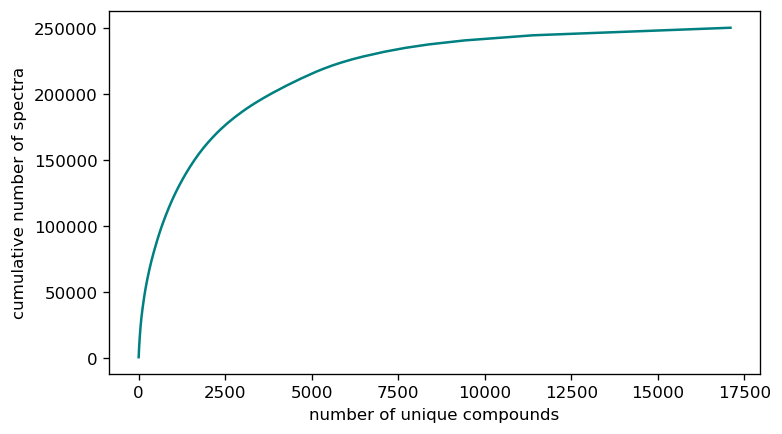

In [19]:
inchikey_frequency = []

for inchikey14 in inchikeys14_unique:
    idx = np.where(inchikeys14 == inchikey14)[0]
    inchikey_frequency.append(idx.shape[0])

inchikey_frequency = np.array(inchikey_frequency)

cumulative = np.cumsum(inchikey_frequency[inchikey_frequency.argsort()][::-1])

plt.figure(figsize=(7,4), dpi=120)
plt.plot(cumulative, c='teal')
plt.xlabel("number of unique compounds")
plt.ylabel("cumulative number of spectra")

(0.0, 2000.0)

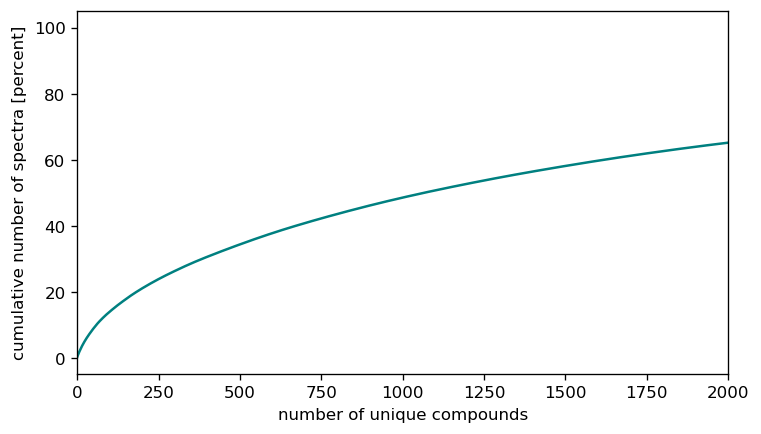

In [57]:
plt.figure(figsize=(7,4), dpi=120)
plt.plot(100 * cumulative/max(cumulative), c='teal')
plt.xlabel("number of unique compounds")
plt.ylabel("cumulative number of spectra [percent]")
plt.xlim((0, 2000))

### the 1000 most frequent inchikeys make up for 50% of the total spectra

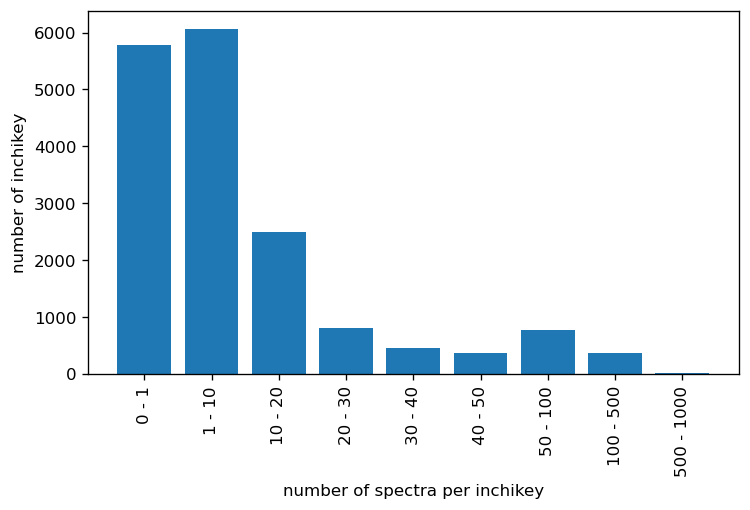

In [53]:
bins = [0, 1.1,10.1, 20.1, 30.1, 40.1, 50.1, 100.1, 500.1, 1000]
labels = [f"{bins[i]:.0f} - {bins[i+1]:.0f}" for i in range(len(bins)-1)]

a,b = np.histogram(inchikey_frequency, bins)

plt.figure(figsize=(7,4), dpi=120)
plt.bar(np.arange(len(a)), a)
plt.xticks(np.arange(len(a)), labels, rotation='vertical')
plt.ylabel("number of inchikey")
plt.xlabel("number of spectra per inchikey")
plt.show()

# Further explore data

(0.0, 100.0)

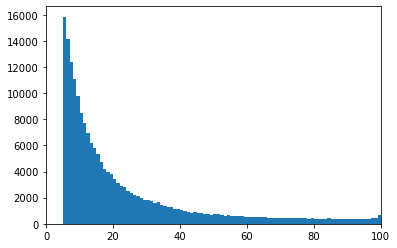

In [66]:
numbers_of_peaks = np.array([len(s.peaks) for s in spectrums_pos_annotated])
plt.hist(numbers_of_peaks, np.linspace(0,100,101))
plt.xlim(0, 100)

In [110]:
for num in [5, 10, 15, 20]:
    print(f"{np.sum(numbers_of_peaks >= num)} spectra with >= {num} peaks.")

250371 spectra with >= 5 peaks.
187147 spectra with >= 10 peaks.
151982 spectra with >= 15 peaks.
129956 spectra with >= 20 peaks.


In [92]:
inchikeys14.shape

(17106,)

Text(0.5, 0, 'parent mass')

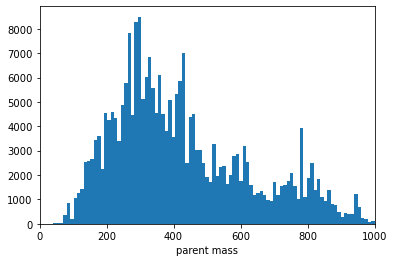

In [71]:
masses = [s.get("parent_mass") for s in spectrums_pos_annotated]
plt.hist(masses, np.linspace(0,1000,100))
plt.xlim(0, 1000)
plt.xlabel("parent mass")

In [ ]:
inchikeys14all = np.array([s.get("inchikey")[:14] for s in spectrums_pos_annotated])

In [84]:
min_num_peaks = 10
select_spectra_subset = []
select_spectra_ids = []

for inchikey in np.unique(inchikeys14all):
    idx = np.where(inchikeys14all == inchikey)[0]
    lengths = numbers_of_peaks[idx]
    select = np.where(lengths >= min_num_peaks)[0]
    if select.shape[0] == 0:
        select = np.argmax(lengths)
    idx_select = idx[select]
    if isinstance(idx_select, np.int64):
        idx_select = [idx_select]
    select_spectra_subset += [idx_select]
    select_spectra_ids +=[x for x in idx_select]

In [104]:
inchikeys14all_10 = np.array([s.get("inchikey")[:14] for s in spectrums_pos_annotated if len(s.peaks)>=10])
np.unique(inchikeys14all_10).shape, inchikeys14all_10.shape, np.unique(inchikeys14all).shape

((16360,), (187147,), (17106,))

(0.0, 100.0)

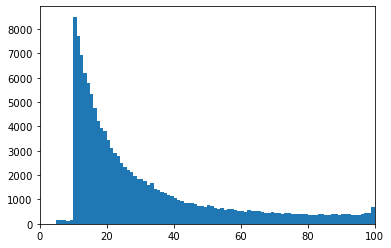

In [90]:
#numbers_of_peaks = np.array([len(s.peaks) for s in spectrums_pos_annotated])
plt.hist(numbers_of_peaks[select_spectra_ids], np.linspace(0,100,101))
plt.xlim(0, 100)

In [97]:
inchikeys14all[select_spectra_ids][:10], len(inchikeys14_unique)

(array(['AAABMNXUOFPYQK', 'AAABMNXUOFPYQK', 'AAABMNXUOFPYQK',
        'AAABMNXUOFPYQK', 'AAABMNXUOFPYQK', 'AABILZKQMVKFHP',
        'AABILZKQMVKFHP', 'AABILZKQMVKFHP', 'AABILZKQMVKFHP',
        'AABILZKQMVKFHP'], dtype='<U14'),
 17106)

Text(0, 0.5, 'cumulative number of spectra')

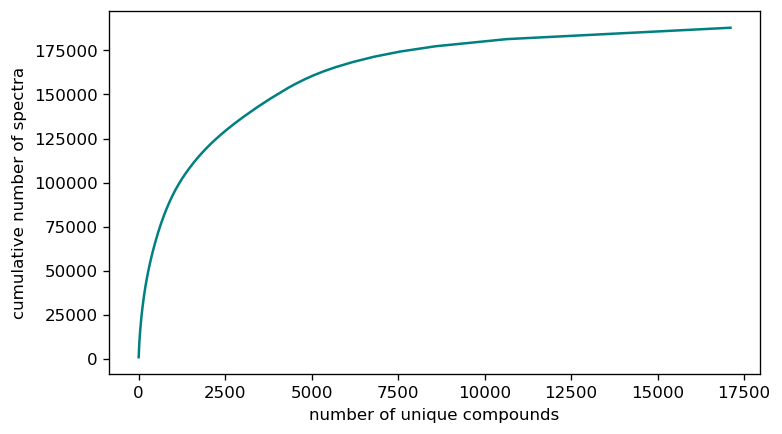

In [98]:
inchikey_frequency = []

for inchikey14 in inchikeys14_unique:
    idx = np.where(inchikeys14all[select_spectra_ids] == inchikey14)[0]
    inchikey_frequency.append(idx.shape[0])

inchikey_frequency = np.array(inchikey_frequency)

cumulative = np.cumsum(inchikey_frequency[inchikey_frequency.argsort()][::-1])

plt.figure(figsize=(7,4), dpi=120)
plt.plot(cumulative, c='teal')
plt.xlabel("number of unique compounds")
plt.ylabel("cumulative number of spectra")

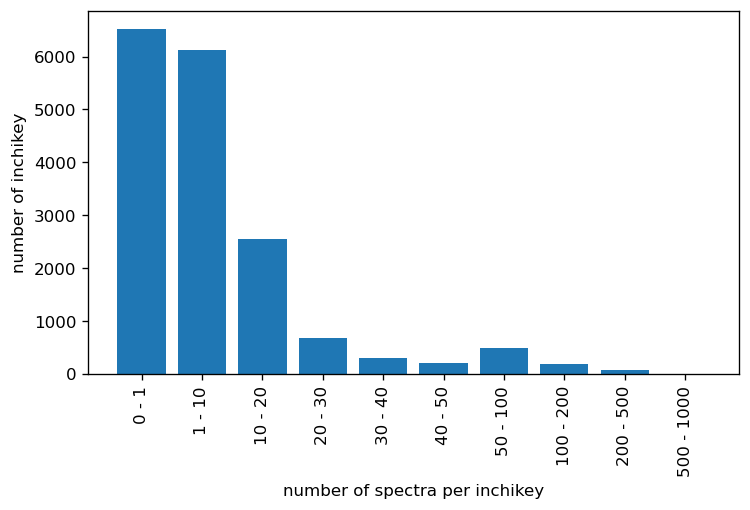

In [103]:
bins = [0, 1.1,10.1, 20.1, 30.1, 40.1, 50.1, 100.1, 200.1, 500.1, 1000]
labels = [f"{bins[i]:.0f} - {bins[i+1]:.0f}" for i in range(len(bins)-1)]

a,b = np.histogram(inchikey_frequency, bins)

plt.figure(figsize=(7,4), dpi=120)
plt.bar(np.arange(len(a)), a)
plt.xticks(np.arange(len(a)), labels, rotation='vertical')
plt.ylabel("number of inchikey")
plt.xlabel("number of spectra per inchikey")
plt.show()

In [88]:
select_spectra_ids = []
for idx_select in select_spectra_subset:
    select_spectra_ids += [x for x in idx_select]

In [86]:
select_spectra_subset[:10]

[array([323, 324, 325, 326, 327], dtype=int64),
 array([77464, 77521, 77556, 77916, 78100, 78151, 78255, 78264, 78761,
        78997, 79093, 79209, 79386, 79558, 79667, 79675, 79972],
       dtype=int64),
 array([584, 585], dtype=int64),
 array([ 15552, 113272], dtype=int64),
 array([51655], dtype=int64),
 array([10837], dtype=int64),
 array([30778, 30779, 31034, 31035, 31306, 31307, 31562, 31563, 32762,
        32763, 34580, 34581, 34902, 34903, 36957, 36958, 37091, 37092,
        37239, 37240, 37409, 37410, 37545, 37546, 37653, 37654, 37809,
        37810, 37975, 37976, 38381, 38382, 38533, 38534, 38617, 38618,
        38879, 38880, 43094, 43095], dtype=int64),
 array([ 13246, 102927, 102928, 102929, 102930, 102931, 102932, 102933,
        102934, 102935, 102936, 102937, 102938], dtype=int64),
 array([65842, 66123, 67033, 67085, 67579, 67861, 68026, 68333, 68547,
        69310], dtype=int64),
 array([21472, 21724, 21749, 52709, 52710, 52711, 52713, 52714, 52715,
        52716, 60390,

In [89]:
len(select_spectra_ids)

187893

In [58]:
import matplotlib
cmap = matplotlib.cm.get_cmap('hsv')

idx = np.where(inchikeys14 == inchikeys14[602])[0] #600
print(idx)

plt.figure(figsize=(8,6), dpi=120)
N = idx.shape[0]
max_mz = 0.0
min_mz = np.inf
for i, ID in enumerate(idx):
    max_mz = max(max_mz, spectrums[ID].peaks.mz.max())
    min_mz = min(min_mz, spectrums[ID].peaks.mz.min())
    x, y = make_stems(spectrums[ID])
    plt.plot(x, y, c=cmap(i/N), linewidth=1, alpha=0.3)
plt.xlim((min_mz, max_mz))
plt.show()

[601 602]


NameError: name 'make_stems' is not defined

<Figure size 960x720 with 0 Axes>

### Load Tanimoto scores (=labels)

In [6]:
filename = os.path.join(path_data, 'ALL_GNPS_210409_positive_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,STZYTFJPGGDRJD,SWTDXMBCOHIACK,HJBWJAPEBGSQPR,VQNWOYVWHDVFJY,WFDXOXNFNRHQEC,GZLIPAFSJXROEC,YTZSBJLNMIQROD,FOULCGVQZYQEQM,BPSJMBKZSUTYNF,PZJVSTTVMXPZCJ,...,VLSRUFWCGBMYDJ,SXXHPCVDFDABHW,MRHAPHFJBAUDTR,ZYCWGZVLCXRARB,CGUNOWXWUXNOPE,MGRVRXRGTBOSHW,WELCNKRQSNXMDQ,XFANDVLPSBUGKD,NDTYTMIUWGWIMO,OAUIRSVJXOFAOO
STZYTFJPGGDRJD,1.000000,0.377404,0.124056,0.269856,0.233411,0.258824,0.354221,0.227136,0.277537,0.316971,...,0.112832,0.177950,0.277099,0.308905,0.341988,0.017219,0.274643,0.298611,0.138404,0.270531
SWTDXMBCOHIACK,0.377404,1.000000,0.158318,0.274962,0.297240,0.324305,0.372534,0.216172,0.274742,0.351300,...,0.140399,0.184380,0.325533,0.353607,0.387618,0.014911,0.364401,0.371447,0.153314,0.366841
HJBWJAPEBGSQPR,0.124056,0.158318,1.000000,0.159198,0.209205,0.200203,0.133133,0.106944,0.201604,0.157643,...,0.753012,0.152395,0.180529,0.188280,0.147473,0.005848,0.199245,0.234842,0.074725,0.180833
VQNWOYVWHDVFJY,0.269856,0.274962,0.159198,1.000000,0.270677,0.261011,0.218063,0.237487,0.228497,0.471683,...,0.149272,0.216159,0.591716,0.370402,0.279240,0.014306,0.288416,0.314224,0.100515,0.262040
WFDXOXNFNRHQEC,0.233411,0.297240,0.209205,0.270677,1.000000,0.329466,0.273837,0.184561,0.258525,0.355102,...,0.194030,0.212011,0.330603,0.312870,0.318026,0.017301,0.319708,0.357045,0.083333,0.351071


---
# Split data

In [7]:
tanimoto_df.index.to_numpy()[:10]

array(['STZYTFJPGGDRJD', 'SWTDXMBCOHIACK', 'HJBWJAPEBGSQPR',
       'VQNWOYVWHDVFJY', 'WFDXOXNFNRHQEC', 'GZLIPAFSJXROEC',
       'YTZSBJLNMIQROD', 'FOULCGVQZYQEQM', 'BPSJMBKZSUTYNF',
       'PZJVSTTVMXPZCJ'], dtype=object)

In [8]:
inchikeys14 = tanimoto_df.index.to_numpy()
inchikeys14.shape

(17106,)

## Decide on data split
- Split data for MS2DeepScore and Spec2Vec model training

In [20]:
spectrums = [s for s in spectrums_pos_processed if len(s.peaks) >= 10]

In [21]:
inchikeys14 = np.array([s.get("inchikey")[:14] for s in spectrums])

### For MS2Query:
Remove 2x (validation + test):
- 250 compounds (Inchikeys)
- 2000 spectra ( of different InChIKeys), which keep at least 1 copy in the training data 

In [25]:
np.unique(inchikeys14).shape, len(spectrums)

((16346,), 185827)

In [22]:
# fixed numbers for validation and testset
n_label = np.unique(inchikeys14).shape[0]

n_val = 250
n_test = 250
n_train = n_label - n_val - n_test
print("Split dataset into train/val/test fractions:", n_train, n_val, n_test)

Split dataset into train/val/test fractions: 15846 250 250


In [26]:
print(f"Train + val: {100 * (n_train + n_val)/n_label:.3f} %")
print(f"Test: {100 * (n_test)/n_label:.3f} %")

Train + val: 98.471 %
Test: 1.529 %


In [83]:
np.random.seed(1234)
inchikey_ids = np.arange(n_label)

# Select training, validation, and test IDs:
train_inchikeyIDs = np.random.choice(inchikey_ids, n_train, replace=False)
val_inchikeyIDs = np.random.choice(list(set(inchikey_ids) - set(train_inchikeyIDs)), n_val, replace=False)
test_inchikeyIDs = list(set(inchikey_ids) - set(train_inchikeyIDs) - set(val_inchikeyIDs))

In [84]:
len(val_inchikeyIDs), len(test_inchikeyIDs)

(250, 250)

In [85]:
train_inchikeyIDs[:20]

array([ 6121,  5443,  4430, 14241,  2681,  2264, 12238,  6860, 15100,
       10171,  4462, 13566,  6674,  8961, 14885,  9026,  4480,  2953,
       11639,  2235])

In [86]:
np.array(test_inchikeyIDs[:20])

array([11777,  5123,  5124, 15877, 11278,  6671,  4112,  3598,  5138,
        7697, 12311,  9247,  6176,  2594,  3107,  6693, 13350,  9767,
        4137,  8745])

In [87]:
# quick check to see if there's indeed no overlap
for idx in train_inchikeyIDs:
    assert (idx not in val_inchikeyIDs) and (idx not in test_inchikeyIDs), f"Found overlap for ID {idx}"
    
for idx in val_inchikeyIDs:
    assert (idx not in test_inchikeyIDs) and (idx not in train_inchikeyIDs), f"Found overlap for ID {idx}"
    
for idx in test_inchikeyIDs:
    assert (idx not in train_inchikeyIDs) and (idx not in val_inchikeyIDs), f"Found overlap for ID {idx}"

### Make selection
- collect all IDs which do not have InChIKey from test or val set
- collect IDs for inchikeys which have > 1 spectrum in dataset

In [88]:
inchikeys14_training = np.unique(inchikeys14)[train_inchikeyIDs]
spectra_with_multiple_copies = []
inchikeys_with_multiple_spectra = []

np.random.seed(1234)
for inchikey in inchikeys14_training:
    idx = np.where(inchikeys14 == inchikey)[0]
    if idx.shape[0] > 1:
        spectra_with_multiple_copies += [x for x in idx]
        inchikeys_with_multiple_spectra.append(inchikey)

In [89]:
len(inchikeys_with_multiple_spectra), len(spectra_with_multiple_copies)

(10244, 175676)

In [90]:
np.random.seed(123)
pick_inchikeys = np.random.choice(inchikeys_with_multiple_spectra, 4000, replace=False)

inchikeys14_val_single_spectrum = pick_inchikeys[:2000]
inchikeys14_test_single_spectrum = pick_inchikeys[2000:]
inchikeys14_val_single_spectrum.shape, inchikeys14_test_single_spectrum.shape

((2000,), (2000,))

In [91]:
inchikeys14_val = np.unique(inchikeys14)[val_inchikeyIDs]

np.random.seed(123)
valIDs = []
for inchikey in inchikeys14_val:
    idx = np.where(inchikeys14 == inchikey)[0]
    valIDs += {x for x in idx}

for inchikey in inchikeys14_val_single_spectrum:
    idx = np.where(inchikeys14 == inchikey)[0]
    valIDs += {np.random.choice(idx, 1)[0]}

In [92]:
len(valIDs)

4299

In [93]:
inchikeys14_test = np.unique(inchikeys14)[test_inchikeyIDs]

np.random.seed(123)
testIDs = []
for inchikey in inchikeys14_test:
    idx = np.where(inchikeys14 == inchikey)[0]
    testIDs += {x for x in idx}

for inchikey in inchikeys14_test_single_spectrum:
    idx = np.where(inchikeys14 == inchikey)[0]
    testIDs += {np.random.choice(idx, 1)[0]}

In [94]:
len(testIDs)

4250

In [95]:
trainIDs = list({i for i in range(len(spectrums))} - set(valIDs) - set(testIDs))
len(trainIDs), len(valIDs), len(testIDs)

(177278, 4299, 4250)

In [96]:
assert len(set(trainIDs).intersection(set(valIDs))) == 0
assert len(set(valIDs).intersection(set(testIDs))) == 0

In [97]:
spectrums_training = [spectrums[i] for i in trainIDs]
print(f"{len(spectrums_training)} spectrums in training data")

177278 spectrums in training data


In [98]:
spectrums_val = [spectrums[i] for i in valIDs]
print(f"{len(spectrums_val)} spectrums in val data")

4299 spectrums in val data


In [99]:
spectrums_test = [spectrums[i] for i in testIDs]
print(f"{len(spectrums_test)} spectrums in test data")

4250 spectrums in test data


### Export splitted datasets

In [100]:
pickle.dump(spectrums_training, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_train_split.pickle'), "wb"))

pickle.dump(spectrums_val, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_val_split.pickle'), "wb"))

pickle.dump(spectrums_test, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_test_split.pickle'), "wb"))

### Spectrum processing...

In [101]:
spectrums_test[0].get("smiles")

'OC(=O)CCC(=O)Nc1ccc(cc1)S(=O)(=O)Nc2nccs2'

(0.0, 1000.0)

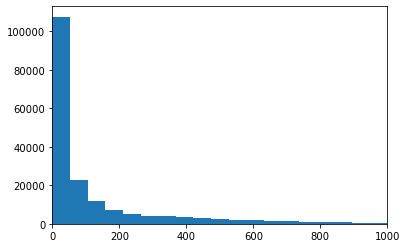

In [41]:
numbers_of_peaks = [len(s.peaks) for s in spectrums]
plt.hist(numbers_of_peaks, np.linspace(0,1000,20))
plt.xlim(0, 1000)

In [42]:
np.min(np.array(numbers_of_peaks)), np.max(np.array(numbers_of_peaks))

(10, 228989)